# OULAD Exploration

This analysis uses the Open University Learning Analytics Dataset (OULAD). It contains data about courses, students and their interactions with Virtual Learning Environment (VLE) for seven selected courses (called modules). Source: https://analyse.kmi.open.ac.uk/open_dataset

## Table of Contents
### [Part I: Descriptive Analysis](#1)
### [Part II: Data Preparation & Feature Engineering](#2)
### [Part III: Predictive Analytics](#3)

<a id='1'></a>
## Part 1: Descriptive Analysis

### *Objective: Help the audience understand  the student body by creating descriptive analysis and highlight interesting trends among various demographic cohorts.*

What are the student performance trends among various demographic cohorts (age, gender, imd_band, highest education etc.)?

In [1]:
import zipfile as zf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
# extract data files to directory 'extractedData' if this code hasn't been executed yet
if not os.path.exists('extractedData'): 
    files = zf.ZipFile("anonymisedData.zip", 'r')
    files.extractall('extractedData')
    files.close()

In [3]:
# read files in as dataframes
assessments = pd.read_csv('extractedData/assessments.csv')
courses = pd.read_csv('extractedData/courses.csv')
studentAssessment = pd.read_csv('extractedData/studentAssessment.csv')
studentInfo = pd.read_csv('extractedData/studentInfo.csv')
studentRegistration = pd.read_csv('extractedData/studentRegistration.csv')
studentVle = pd.read_csv('extractedData/studentVle.csv')
vle = pd.read_csv('extractedData/vle.csv')

In [4]:
# create function to investigate dataframes
def explore_df(df):
    '''
    Prints information about given dataframe.

    Parameters:
        df (pandas.core.frame.DataFrame):The dataframe of interest.

    Returns:
        None.
    '''
    print('Head:\n', df.head(n = 10))
    print('\nShape:\n', df.shape)
    print('\nData Types:\n', df.dtypes)
    print('\nNaNs:\n', df.isnull().sum())

In [5]:
explore_df(assessments)

Head:
   code_module code_presentation  id_assessment assessment_type   date  weight
0         AAA             2013J           1752             TMA   19.0    10.0
1         AAA             2013J           1753             TMA   54.0    20.0
2         AAA             2013J           1754             TMA  117.0    20.0
3         AAA             2013J           1755             TMA  166.0    20.0
4         AAA             2013J           1756             TMA  215.0    30.0
5         AAA             2013J           1757            Exam    NaN   100.0
6         AAA             2014J           1758             TMA   19.0    10.0
7         AAA             2014J           1759             TMA   54.0    20.0
8         AAA             2014J           1760             TMA  117.0    20.0
9         AAA             2014J           1761             TMA  166.0    20.0

Shape:
 (206, 6)

Data Types:
 code_module           object
code_presentation     object
id_assessment          int64
assessment_type 

In [6]:
explore_df(courses)

Head:
   code_module code_presentation  module_presentation_length
0         AAA             2013J                         268
1         AAA             2014J                         269
2         BBB             2013J                         268
3         BBB             2014J                         262
4         BBB             2013B                         240
5         BBB             2014B                         234
6         CCC             2014J                         269
7         CCC             2014B                         241
8         DDD             2013J                         261
9         DDD             2014J                         262

Shape:
 (22, 3)

Data Types:
 code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object

NaNs:
 code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64


In [7]:
explore_df(studentAssessment)

Head:
    id_assessment  id_student  date_submitted  is_banked  score
0           1752       11391              18          0   78.0
1           1752       28400              22          0   70.0
2           1752       31604              17          0   72.0
3           1752       32885              26          0   69.0
4           1752       38053              19          0   79.0
5           1752       45462              20          0   70.0
6           1752       45642              18          0   72.0
7           1752       52130              19          0   72.0
8           1752       53025               9          0   71.0
9           1752       57506              18          0   68.0

Shape:
 (173912, 5)

Data Types:
 id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object

NaNs:
 id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dty

In [8]:
explore_df(studentInfo)

Head:
   code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   
5         AAA             2013J       38053      M                 Wales   
6         AAA             2013J       45462      M              Scotland   
7         AAA             2013J       45642      F  North Western Region   
8         AAA             2013J       52130      F   East Anglian Region   
9         AAA             2013J       53025      M          North Region   

             highest_education imd_band age_band  num_of_prev_attempts  \
0             HE Qualification  90-100%     55<=                     0   
1       

In [9]:
studentInfo['imd_band'] = studentInfo['imd_band'].astype('str') # convert column from type 'object' to 'string'

In [10]:
studentInfo['final_result'].unique()

array(['Pass', 'Withdrawn', 'Fail', 'Distinction'], dtype=object)

In [11]:
# create secondary column with only the binary result ('Pass' vs. 'Fail')
studentInfo['binary_final_result'] = studentInfo['final_result'].replace({'Withdrawn': 'Fail', 'Distinction': 'Pass'})
studentInfo[['final_result', 'binary_final_result']].tail(n = 10) # sanity check

,final_result,binary_final_result
32583,Pass,Pass
32584,Pass,Pass
32585,Pass,Pass
32586,Withdrawn,Fail
32587,Distinction,Pass
32588,Fail,Fail
32589,Distinction,Pass
32590,Pass,Pass
32591,Withdrawn,Fail
32592,Distinction,Pass


Text(0.5, 1.0, 'Students Passing vs. Failure')

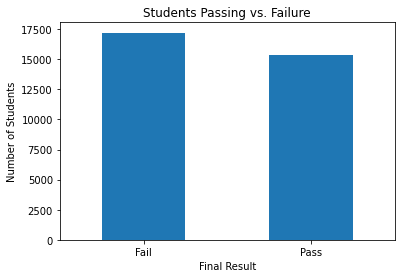

In [12]:
ax = studentInfo['binary_final_result'].value_counts().plot(kind = 'bar', rot = 0)
ax.set_xlabel('Final Result')
ax.set_ylabel('Number of Students')
ax.set_title('Students Passing vs. Failure')

In [13]:
explore_df(studentRegistration)

Head:
   code_module code_presentation  id_student  date_registration  \
0         AAA             2013J       11391             -159.0   
1         AAA             2013J       28400              -53.0   
2         AAA             2013J       30268              -92.0   
3         AAA             2013J       31604              -52.0   
4         AAA             2013J       32885             -176.0   
5         AAA             2013J       38053             -110.0   
6         AAA             2013J       45462              -67.0   
7         AAA             2013J       45642              -29.0   
8         AAA             2013J       52130              -33.0   
9         AAA             2013J       53025             -179.0   

   date_unregistration  
0                  NaN  
1                  NaN  
2                 12.0  
3                  NaN  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN  
8                  NaN  
9               

In [14]:
explore_df(studentVle)

Head:
   code_module code_presentation  id_student  id_site  date  sum_click
0         AAA             2013J       28400   546652   -10          4
1         AAA             2013J       28400   546652   -10          1
2         AAA             2013J       28400   546652   -10          1
3         AAA             2013J       28400   546614   -10         11
4         AAA             2013J       28400   546714   -10          1
5         AAA             2013J       28400   546652   -10          8
6         AAA             2013J       28400   546876   -10          2
7         AAA             2013J       28400   546688   -10         15
8         AAA             2013J       28400   546662   -10         17
9         AAA             2013J       28400   546890   -10          1

Shape:
 (10655280, 6)

Data Types:
 code_module          object
code_presentation    object
id_student            int64
id_site               int64
date                  int64
sum_click             int64
dtype: object

NaN

In [15]:
explore_df(vle)

Head:
    id_site code_module code_presentation activity_type  week_from  week_to
0   546943         AAA             2013J      resource        NaN      NaN
1   546712         AAA             2013J     oucontent        NaN      NaN
2   546998         AAA             2013J      resource        NaN      NaN
3   546888         AAA             2013J           url        NaN      NaN
4   547035         AAA             2013J      resource        NaN      NaN
5   546614         AAA             2013J      homepage        NaN      NaN
6   546897         AAA             2013J           url        NaN      NaN
7   546678         AAA             2013J     oucontent        NaN      NaN
8   546933         AAA             2013J      resource        NaN      NaN
9   546708         AAA             2013J     oucontent        NaN      NaN

Shape:
 (6364, 6)

Data Types:
 id_site                int64
code_module           object
code_presentation     object
activity_type         object
week_from          

Now we will explore student performance trends among various demographic cohorts (age, gender, imd_band , highest education etc.)

#### Age

In [16]:
studentInfo['age_band'].unique()

array(['55<=', '35-55', '0-35'], dtype=object)

Text(0.5, 1.0, 'Student Ages')

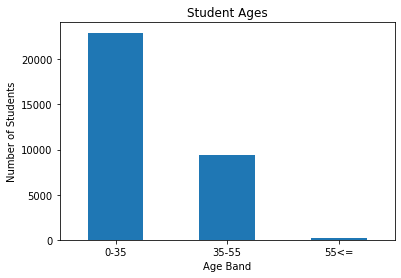

In [17]:
ax = studentInfo['age_band'].value_counts().plot(kind = 'bar', rot = 0)
ax.set_xlabel('Age Band')
ax.set_ylabel('Number of Students')
ax.set_title('Student Ages')

We see that the majority of students are within the 0-35 age bracket and that students 55<= are underrepresented.

binary_final_result   Fail   Pass
age_band                         
0-35                 12612  10332
35-55                 4513   4920
55<=                    83    133


Text(0.5, 1.0, 'Student Performance by Age Band')

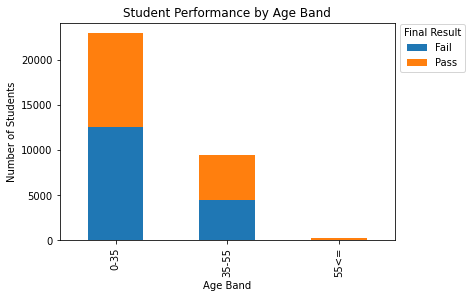

In [18]:
# Multi-dimensional visualization of region and imd_band (resource used: https://stackoverflow.com/questions/43544694/using-pandas-crosstab-to-create-a-bar-plot)
ct = pd.crosstab(studentInfo.age_band, studentInfo.binary_final_result)
print(ct) # sanity check
ax = ct.plot(kind='bar', stacked=True)
ax.legend(title='Final Result', bbox_to_anchor=(1, 1.02), loc='upper left')
ax.set_xlabel('Age Band')
ax.set_ylabel('Number of Students')
ax.set_title('Student Performance by Age Band')

It appears that within the 0-35 and 35-55 age band, the pass-fail rate is approximately 50-50%. It is impossible to confirm that this is the case with the 55<= age band, so I will create this same visualization as side-by-side pie charts:

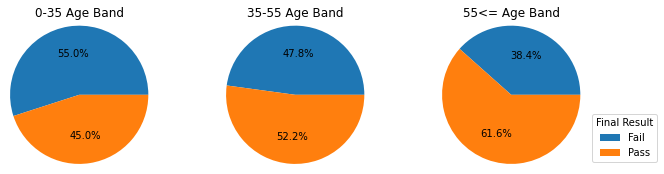

In [19]:
fig = plt.figure()

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(ct.iloc[0, :], labels = None, radius = 1.2, autopct='%1.1f%%')
ax1.set_title(ct.index[0] + ' Age Band')

ax2 = fig.add_axes([.5, .0, .5, .5], aspect=1)
ax2.pie(ct.iloc[1, :], labels = None, radius = 1.2, autopct='%1.1f%%')
ax2.set_title(ct.index[1] + ' Age Band')

ax3 = fig.add_axes([1, 0, .5, .5], aspect=1)
ax3.pie(ct.iloc[2, :], labels = None, radius = 1.2, autopct='%1.1f%%')
ax3.set_title(ct.index[2] + ' Age Band')

# source used: https://www.askpython.com/python/plot-customize-pie-chart-in-python
plt.legend(labels = ['Fail', 'Pass'], bbox_to_anchor=(1.6,0), loc="lower right", bbox_transform=plt.gcf().transFigure, title = 'Final Result')
plt.show()

The likelihood of a student in the 55<= age band failing a module-presentation is lower than all other age bands.

What are the trends between the highest education level upon registration and age band? Do most of the students in the 55< Age Band belong to a particular education level?

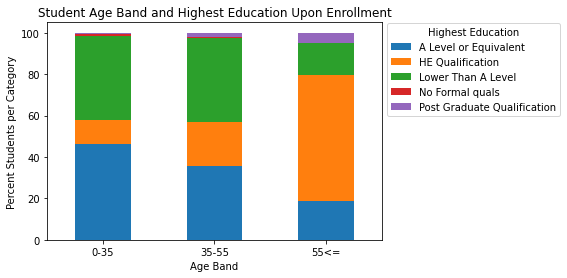

In [20]:
groupedCount = studentInfo.groupby(['age_band','highest_education'])['id_student'].count()
groupedPercent = groupedCount.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).unstack()

groupedPercent.plot(kind='bar', stacked=True, rot = 0)
plt.title('Student Age Band and Highest Education Upon Enrollment')
plt.xlabel('Age Band')
plt.ylabel('Percent Students per Category')
plt.legend(title = 'Highest Education', bbox_to_anchor=(1, 1.02), loc='upper left')

#### Gender

Text(0.5, 1.0, 'Student Gender')

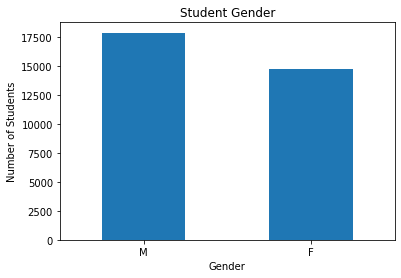

In [21]:
ax = studentInfo['gender'].value_counts().plot(kind = 'bar', rot = 0)
ax.set_xlabel('Gender')
ax.set_ylabel('Number of Students')
ax.set_title('Student Gender')

There are ~3,000 more male students than there are female students. 

In [22]:
# create function to convert groupby count results into percentages
def groupedPercent(category):
    '''
    Takes in a StudentInfo column name and returns a dataframe containing the percentages of students in each category passing/failing.

    Parameters:
        category (str): Represents the column name of interest from the DataFrame StudentInfo.  

    Returns:
        groupedPercent (pandas.core.frame.DataFrame): A grouped DataFrame containing the percentages of each student passing and failing the module-presentation per category. )
    '''
    groupedCount = studentInfo.groupby([category,'binary_final_result'])['id_student'].count()
    groupedPercent = groupedCount.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).unstack()
    return groupedPercent

In [23]:
# convert this into percentages
genderResult = groupedPercent('gender')
print(genderResult) # check

binary_final_result       Fail       Pass
gender                                   
F                    51.562712  48.437288
M                    53.812587  46.187413


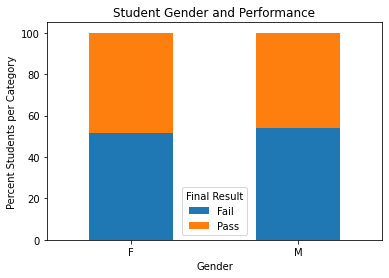

In [24]:
genderResult.plot(kind='bar', stacked=True, rot = 0)

plt.title('Student Gender and Performance')
plt.xlabel('Gender')
plt.ylabel('Percent Students per Category')
plt.legend(loc = 'best', title = 'Final Result')

#### Disability

Text(0.5, 1.0, 'Students with Declared Disabilities')

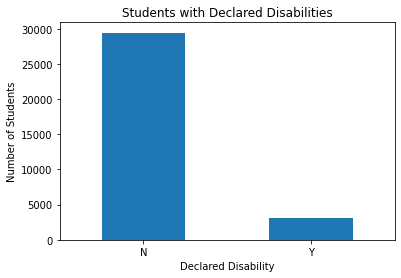

In [25]:
ax = studentInfo['disability'].value_counts().plot(kind = 'bar', rot = 0)
ax.set_xlabel('Declared Disability')
ax.set_ylabel('Number of Students')
ax.set_title('Students with Declared Disabilities')

There are ~26,000 more students without declared disabilities than there are with declared disabilities.

In [26]:
# convert this into percentages
disabilityResult = groupedPercent('disability')
print(disabilityResult) # check

binary_final_result       Fail       Pass
disability                               
N                    51.823032  48.176968
Y                    61.852086  38.147914


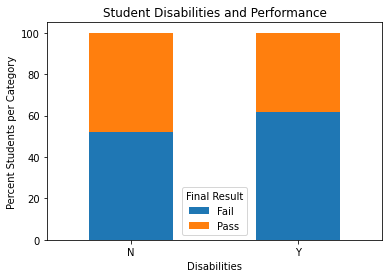

In [27]:
disabilityResult.plot(kind='bar', stacked=True, rot = 0)

plt.title('Student Disabilities and Performance')
plt.xlabel('Disabilities')
plt.ylabel('Percent Students per Category')
plt.legend(loc = 'best', title = 'Final Result')

#### Highest Education

Text(0.5, 1.0, 'Highest Education Level Upon Registration')

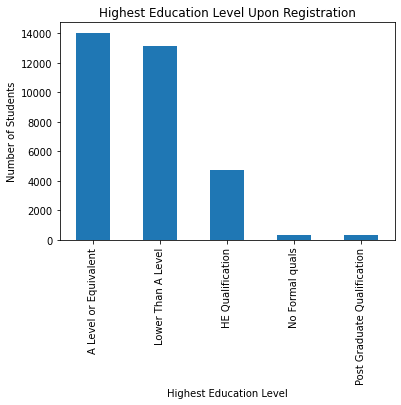

In [28]:
ax = studentInfo['highest_education'].value_counts().plot(kind = 'bar')
ax.set_xlabel('Highest Education Level')
ax.set_ylabel('Number of Students')
ax.set_title('Highest Education Level Upon Registration')

In [29]:
eduResult = groupedPercent('highest_education')
print(eduResult) # check

binary_final_result               Fail       Pass
highest_education                                
A Level or Equivalent        47.967248  52.032752
HE Qualification             43.826638  56.173362
Lower Than A Level           61.149111  38.850889
No Formal quals              70.317003  29.682997
Post Graduate Qualification  34.504792  65.495208


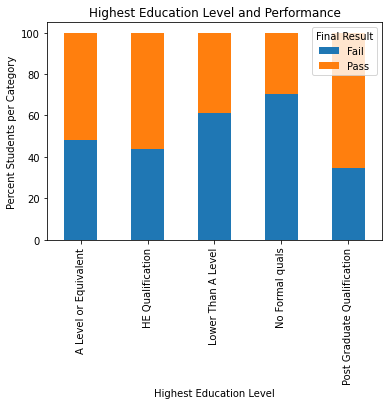

In [30]:
eduResult.plot(kind='bar', stacked=True)

plt.title('Highest Education Level and Performance')
plt.xlabel('Highest Education Level')
plt.ylabel('Percent Students per Category')
plt.legend(loc = 'best', title = 'Final Result')

#### Region

In [31]:
studentInfo['region'].unique() # check how many unique regions there are

array(['East Anglian Region', 'Scotland', 'North Western Region',
       'South East Region', 'West Midlands Region', 'Wales',
       'North Region', 'South Region', 'Ireland', 'South West Region',
       'East Midlands Region', 'Yorkshire Region', 'London Region'],
      dtype=object)

In [32]:
# group the dataframe to get counts of students per region
dfRegion = studentInfo.groupby('region')['id_student'].count().reset_index().sort_values(by=['id_student'], ascending=False)
dfRegion # check

,region,id_student
6,Scotland,3446
0,East Anglian Region,3340
3,London Region,3216
8,South Region,3092
5,North Western Region,2906
11,West Midlands Region,2582
9,South West Region,2436
1,East Midlands Region,2365
7,South East Region,2111
10,Wales,2086


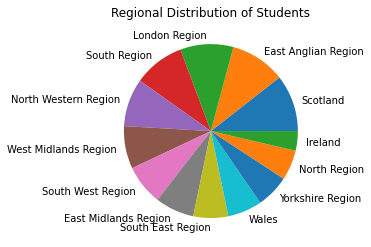

In [33]:
plt.pie(dfRegion['id_student'], labels = dfRegion['region'])
plt.title('Regional Distribution of Students')
plt.show() 

#### IMD Band

Text(0.5, 1.0, 'Student IMD Band')

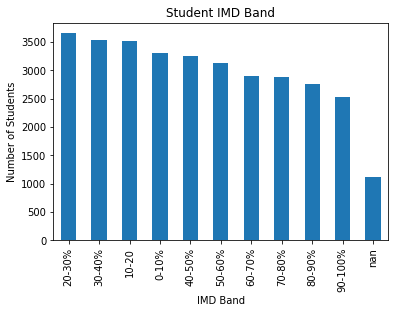

In [34]:
ax = studentInfo['imd_band'].value_counts().plot(kind = 'bar')
ax.set_xlabel('IMD Band')
ax.set_ylabel('Number of Students')
ax.set_title('Student IMD Band')

The x-axis labels are not in sequential order as we would expect and the 10-20 band is missing the percent symbol. We can also drop the 1,111 NaNs from this plot.  Let's fix this:

Text(0.5, 1.0, 'Student IMD Band')

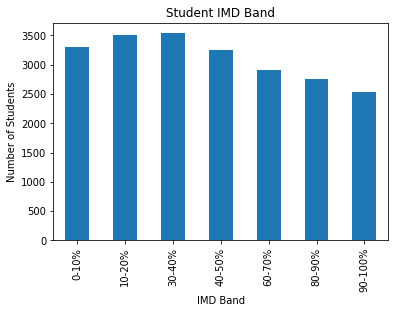

In [35]:
studentInfo.loc[studentInfo['imd_band'] == '10-20', 'imd_band'] = '10-20%'
studentInfo_temp = studentInfo['imd_band'].dropna(inplace = False)

order = ['0-10%', '10-20%', '30-40%','40-50%','60-70%','80-90%','90-100%']
ax = studentInfo['imd_band'].value_counts().loc[order].plot(kind = 'bar')
ax.set_xlabel('IMD Band')
ax.set_ylabel('Number of Students')
ax.set_title('Student IMD Band')

Out of curiosity, is there an obvious relationship between the regions and the IMD Bands?

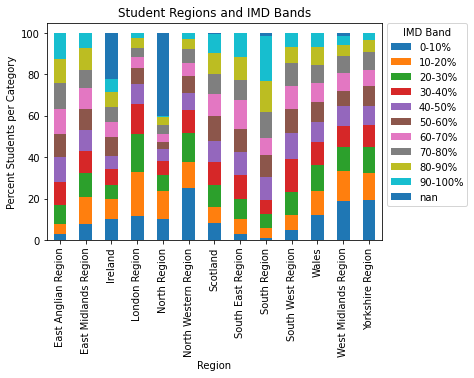

In [37]:
groupedCount = studentInfo.groupby(['region','imd_band'])['id_student'].count()
groupedPercent = groupedCount.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).unstack()

groupedPercent.plot(kind='bar', stacked=True)
plt.title('Student Regions and IMD Bands')
plt.xlabel('Region')
plt.ylabel('Percent Students per Category')
plt.legend(title = 'IMD Band', bbox_to_anchor=(1, 1.02), loc='upper left')

At what point in the code_presentation(course) are students withdrawing the most? What trends do we see among the student demographic cohorts in terms of withdrawal times?

In [38]:
# students who withdrew:
studentDropped = studentRegistration.loc[~studentRegistration['date_unregistration'].isnull()].sort_values(by='date_unregistration')
studentDropped.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
26576,FFF,2014B,535460,NaN,-365.0
5305,BBB,2014B,571732,-322.0,-317.0
26318,FFF,2014B,301128,-305.0,-297.0
16430,DDD,2014B,263022,-295.0,-274.0
13578,DDD,2013B,485943,-274.0,-271.0


Do particular modules tend to have more course withdrawals than others?

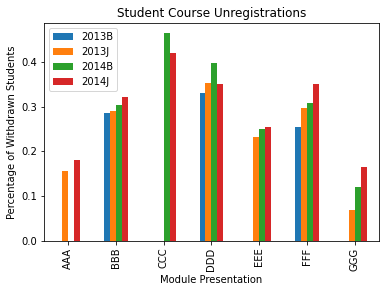

In [39]:
groupedDropped = studentDropped.groupby(['code_module','code_presentation'])['id_student'].count().unstack()
groupedTotal = studentInfo.groupby(['code_module', 'code_presentation'])['id_student'].count().unstack() # total students in module presentation
groupedPercent = (groupedDropped/groupedTotal) # get percentage of unregistered students per module presentation

groupedPercent.plot(kind='bar')
plt.title('Student Course Unregistrations')
plt.xlabel('Module Presentation')
plt.ylabel('Percentage of Withdrawn Students')
plt.legend(loc = 'best')

The module-presentation with the highest percentage of students who have unregistered is (CCC, 2014B). The module presentation with the lowest is (GGG, 2013J). For (CCC, 2014B), what are the trends within this course relative to the assignments given?

In [40]:
CCC_2014B = studentDropped[(studentDropped['code_module'] == 'CCC') & (studentDropped['code_presentation'] == '2014B')]

In [41]:
CCC_2014B_assess = assessments[(assessments['code_module'] == 'CCC') & (assessments['code_presentation'] == '2014B')]
print(CCC_2014B_assess)

   code_module code_presentation  id_assessment assessment_type   date  weight
54         CCC             2014B          24286             CMA   18.0     2.0
55         CCC             2014B          24287             CMA   67.0     7.0
56         CCC             2014B          24288             CMA  137.0     8.0
57         CCC             2014B          24289             CMA  207.0     8.0
58         CCC             2014B          24282             TMA   32.0     9.0
59         CCC             2014B          24283             TMA  102.0    22.0
60         CCC             2014B          24284             TMA  151.0    22.0
61         CCC             2014B          24285             TMA  200.0    22.0
62         CCC             2014B          24290            Exam    NaN   100.0
63         CCC             2014B          40087            Exam    NaN   100.0


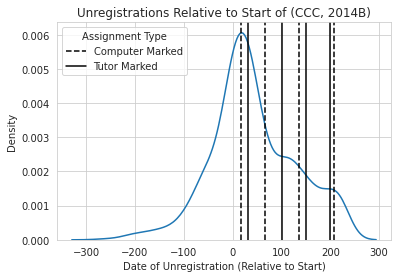

In [42]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig = sns.kdeplot(CCC_2014B['date_unregistration']) 
fig.set(xlabel = 'Date of Unregistration (Relative to Start)', ylabel = 'Density', title ='Unregistrations Relative to Start of (CCC, 2014B)')
assessDatesCMA = CCC_2014B_assess['date'][CCC_2014B_assess['assessment_type'] == 'CMA'].values
assessDatesTMA = CCC_2014B_assess['date'][CCC_2014B_assess['assessment_type'] == 'TMA'].values

for i in assessDatesCMA:
    plt.axvline(x = i, c = 'black', ls = '--')
for i in assessDatesTMA:
    plt.axvline(x = i, c = 'black')

custom_lines = [Line2D([0], [0], color= 'black', ls = '--'),
                Line2D([0], [0], color='black')]


ax.legend(custom_lines, ['Computer Marked', 'Tutor Marked'], title = 'Assignment Type')
#resource used: https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html

Text(0.5, 1.0, 'Unregistrations Relative to Start of Course')

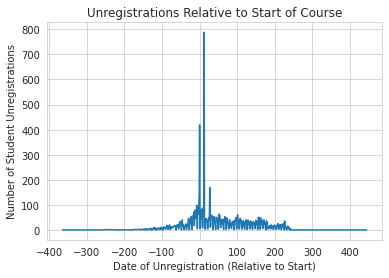

In [43]:
studentDropped.groupby(['date_unregistration'])['id_student'].count().plot()
plt.xlabel('Date of Unregistration (Relative to Start)')
plt.ylabel('Number of Student Unregistrations')
plt.title('Unregistrations Relative to Start of Course')

We can see that most students are unregistering on the start of the course or directly before. However, this plot is very jittery and a kernal density plot would look nicer (which is much easier to do in seaborn than matplotlib; resource used: https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlib):

[Text(0.5, 0, 'Date of Unregistration (Relative to Start)'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Unregistrations Relative to Start of Course')]

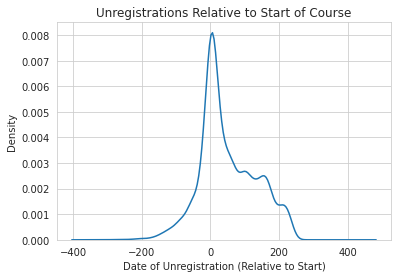

In [44]:
sns.set_style('whitegrid')
fig = sns.kdeplot(studentDropped['date_unregistration'])
fig.set(xlabel = 'Date of Unregistration (Relative to Start)', ylabel = 'Density', title ='Unregistrations Relative to Start of Course')

To analyze trends among different demographics, we must merge this unregistration data (studentDropped) with studentInfo:

In [45]:
studentDropped = studentDropped.merge(studentInfo[['id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability']], on = 'id_student')
studentDropped.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,gender,region,highest_education,imd_band,age_band,disability
0,FFF,2014B,535460,NaN,-365.0,M,London Region,A Level or Equivalent,60-70%,0-35,N
1,FFF,2014B,535460,NaN,-365.0,M,London Region,A Level or Equivalent,60-70%,0-35,N
2,BBB,2014B,571732,-322.0,-317.0,F,South East Region,Lower Than A Level,70-80%,35-55,N
3,FFF,2014B,301128,-305.0,-297.0,M,East Midlands Region,A Level or Equivalent,30-40%,0-35,N
4,FFF,2014B,301128,-305.0,-297.0,M,East Midlands Region,A Level or Equivalent,30-40%,0-35,N


[Text(0.5, 0, 'Date of Unregistration (Relative to Start)'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Unregistrations Relative to Start of Course')]

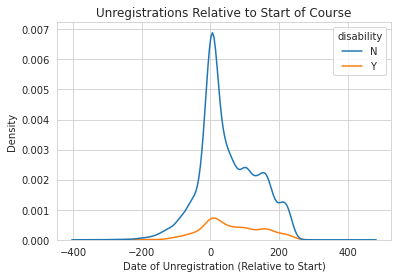

In [46]:
sns.set_style('whitegrid')
fig = sns.kdeplot(x='date_unregistration', data = studentDropped[['disability','date_unregistration']], hue = 'disability')
fig.set(xlabel = 'Date of Unregistration (Relative to Start)', ylabel = 'Density', title ='Unregistrations Relative to Start of Course')

[Text(0.5, 0, 'Date of Unregistration (Relative to Start)'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Unregistrations Relative to Start of Course')]

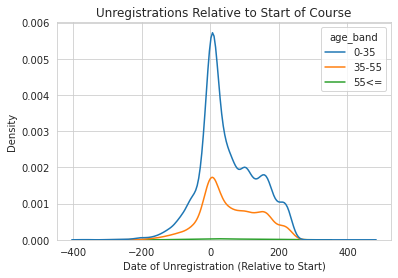

In [47]:
sns.set_style('whitegrid')
fig = sns.kdeplot(x='date_unregistration', data = studentDropped[['age_band','date_unregistration']], hue = 'age_band')
fig.set(xlabel = 'Date of Unregistration (Relative to Start)', ylabel = 'Density', title ='Unregistrations Relative to Start of Course')

[Text(0.5, 0, 'Date of Unregistration (Relative to Start)'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Unregistrations Relative to Start of Course')]

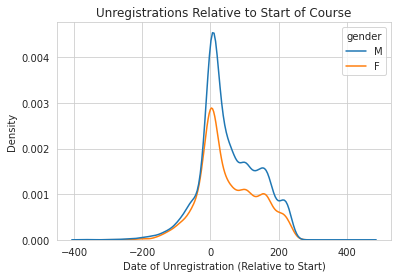

In [48]:
sns.set_style('whitegrid')
fig = sns.kdeplot(x='date_unregistration', data = studentDropped[['gender','date_unregistration']], hue = 'gender')
fig.set(xlabel = 'Date of Unregistration (Relative to Start)', ylabel = 'Density', title ='Unregistrations Relative to Start of Course')

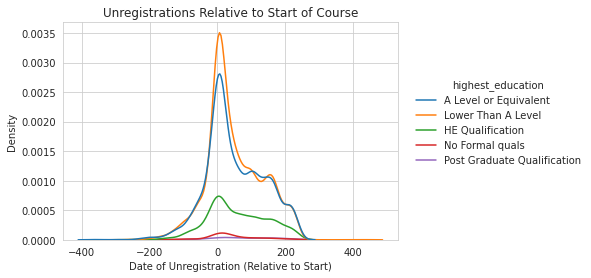

In [49]:
sns.set_style('whitegrid')
fig = sns.kdeplot(x='date_unregistration', data = studentDropped[['highest_education','date_unregistration']], hue = 'highest_education')
fig.set(xlabel = 'Date of Unregistration (Relative to Start)', ylabel = 'Density', title ='Unregistrations Relative to Start of Course')
sns.move_legend(fig, "lower center", bbox_to_anchor=(1.3, 0.3), frameon=False)

<a id='2'></a>
## Part II: Data Preparation & Feature Engineering

### *Objective: Track student assessment submissions. Prepare an analysis to create a metric to calculate percentage of late submissions for each student registration.*

In [50]:
print(studentAssessment.head())

assessments.head()

   id_assessment  id_student  date_submitted  is_banked  score
0           1752       11391              18          0   78.0
1           1752       28400              22          0   70.0
2           1752       31604              17          0   72.0
3           1752       32885              26          0   69.0
4           1752       38053              19          0   79.0


,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [51]:
# merge studentAssessment data with assessments
assessmentsDue = studentAssessment.merge(assessments, on='id_assessment')
assessmentsDue.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0


In [52]:
assessmentsDue.rename(columns = {'date' : 'due_date'}, inplace = True) # rename 'date' into something more obvious
assessmentsDue.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,due_date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0


In [53]:
# combine this with studentRegistration in case student has unregistered:
assessmentsDue = assessmentsDue.merge(studentRegistration, on = ['id_student', 'code_module', 'code_presentation'])
assessmentsDue.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,due_date,weight,date_registration,date_unregistration
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,-159.0,NaN
1,1753,11391,53,0,85.0,AAA,2013J,TMA,54.0,20.0,-159.0,NaN
2,1754,11391,115,0,80.0,AAA,2013J,TMA,117.0,20.0,-159.0,NaN
3,1755,11391,164,0,85.0,AAA,2013J,TMA,166.0,20.0,-159.0,NaN
4,1756,11391,212,0,82.0,AAA,2013J,TMA,215.0,30.0,-159.0,NaN


In [54]:
# focus on a single student and module presentation for now:
assessmentsDue_temp = assessmentsDue[(assessmentsDue['id_student'] == 11391) & (assessmentsDue['code_presentation'] == '2013J') & (assessmentsDue['code_module'] == 'AAA')]
assessmentsDue_temp

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,due_date,weight,date_registration,date_unregistration
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,-159.0,NaN
1,1753,11391,53,0,85.0,AAA,2013J,TMA,54.0,20.0,-159.0,NaN
2,1754,11391,115,0,80.0,AAA,2013J,TMA,117.0,20.0,-159.0,NaN
3,1755,11391,164,0,85.0,AAA,2013J,TMA,166.0,20.0,-159.0,NaN
4,1756,11391,212,0,82.0,AAA,2013J,TMA,215.0,30.0,-159.0,NaN


Comparing the date_submitted and due_date of each row, we see that this student does not have any late assessments. Therefore, their score should be zero. 

In [55]:
score_temp = sum(assessmentsDue_temp['date_submitted'] > assessmentsDue_temp['due_date'])/(assessmentsDue_temp.shape[0])
score_temp

0.0

We'd like to create a column in studentRegistration named 'percent_late' for each registration. To do this, we will follow a similar procedure:

In [56]:
studentRegistration['percent_late'] = np.nan
for index, row in studentRegistration.iterrows():
    id_student = row['id_student']
    code_presentation = row['code_presentation']
    code_module = row['code_module']
    assessmentsDue_temp = assessmentsDue[(assessmentsDue['id_student'] == id_student) & (assessmentsDue['code_presentation'] == code_presentation) & (assessmentsDue['code_module'] == code_module)]
    if (assessmentsDue_temp.shape[0] > 0): # if one or more assignment has been submitted
        score_temp = sum(assessmentsDue_temp['date_submitted'] > assessmentsDue_temp['due_date'])/(assessmentsDue_temp.shape[0])
        studentRegistration.loc[index, 'percent_late'] = (score_temp* 100) 
    else:
        pass

In [57]:
studentRegistration.head(n = 50) # let's take a look

,code_module,code_presentation,id_student,date_registration,date_unregistration,percent_late
0,AAA,2013J,11391,-159.0,NaN,0.000000
1,AAA,2013J,28400,-53.0,NaN,40.000000
2,AAA,2013J,30268,-92.0,12.0,NaN
3,AAA,2013J,31604,-52.0,NaN,0.000000
4,AAA,2013J,32885,-176.0,NaN,100.000000
5,AAA,2013J,38053,-110.0,NaN,20.000000
6,AAA,2013J,45462,-67.0,NaN,40.000000
7,AAA,2013J,45642,-29.0,NaN,40.000000
8,AAA,2013J,52130,-33.0,NaN,20.000000
9,AAA,2013J,53025,-179.0,NaN,0.000000


In [58]:
# Reformat column to only two decimal places:
studentRegistration.percent_late = studentRegistration.percent_late.round(2)
studentRegistration.head() 

,code_module,code_presentation,id_student,date_registration,date_unregistration,percent_late
0,AAA,2013J,11391,-159.0,NaN,0.0
1,AAA,2013J,28400,-53.0,NaN,40.0
2,AAA,2013J,30268,-92.0,12.0,NaN
3,AAA,2013J,31604,-52.0,NaN,0.0
4,AAA,2013J,32885,-176.0,NaN,100.0


Create a pivot table on VLE activity types to get total sum clicks per activity type for each student registration.

In [59]:
# merge studentRegistration with studentVle and vle:
vleActivity = studentRegistration.merge(studentVle, on = ['code_module', 'code_presentation', 'id_student'])
vleActivity = vleActivity.merge(vle, on = ['code_module', 'code_presentation', 'id_site'])
vleActivity.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,percent_late,id_site,date,sum_click,activity_type,week_from,week_to
0,AAA,2013J,11391,-159.0,NaN,0.0,546669,-5,16,oucontent,NaN,NaN
1,AAA,2013J,11391,-159.0,NaN,0.0,546669,17,15,oucontent,NaN,NaN
2,AAA,2013J,28400,-53.0,NaN,40.0,546669,6,4,oucontent,NaN,NaN
3,AAA,2013J,28400,-53.0,NaN,40.0,546669,7,1,oucontent,NaN,NaN
4,AAA,2013J,32885,-176.0,NaN,100.0,546669,13,3,oucontent,NaN,NaN


In [60]:
# rename 'date' into something more self-explanatory
vleActivity.rename(columns = {'date' : 'date_of_interation'}, inplace = True)

# preserve only the relevant columns and re-order:
vleActivity = vleActivity[['id_student', 'code_module', 'code_presentation', 'activity_type', 'sum_click']]
vleActivity.head()

,id_student,code_module,code_presentation,activity_type,sum_click
0,11391,AAA,2013J,oucontent,16
1,11391,AAA,2013J,oucontent,15
2,28400,AAA,2013J,oucontent,4
3,28400,AAA,2013J,oucontent,1
4,32885,AAA,2013J,oucontent,3


In [61]:
# use groupby to get total sum clicks per activity type for each student registration.
vleActivity_groupby = vleActivity.groupby(['id_student', 'code_module', 'code_presentation', 'activity_type'])['sum_click'].agg(np.sum).reset_index()
vleActivity_groupby.head()

,id_student,code_module,code_presentation,activity_type,sum_click
0,6516,AAA,2014J,dataplus,21
1,6516,AAA,2014J,forumng,451
2,6516,AAA,2014J,homepage,497
3,6516,AAA,2014J,oucontent,1505
4,6516,AAA,2014J,resource,31


Text(0.5, 1.0, 'Distribution of Activity Types')

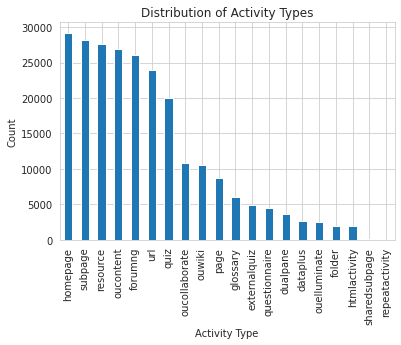

In [62]:
# plot activity type distribution
ax = vleActivity_groupby['activity_type'].value_counts().plot(kind = 'bar')
ax.set_xlabel('Activity Type')
ax.set_ylabel('Count')
ax.set_title('Distribution of Activity Types')

In [63]:
# Create a pivot table on VLE activity types to get total sum clicks per activity type for each student registration
vleActivity_pivot = pd.pivot_table(vleActivity_groupby, values='sum_click', index=['id_student', 'code_module', 'code_presentation'], aggfunc=np.sum)
vleActivity_pivot.tail(10)

sum_click
id_student code_module code_presentation           
2697885    FFF         2014B                   1986
2697921    FFF         2013J                   2319
                       2014J                   1767
2698125    FFF         2013J                   1243
2698251    DDD         2014B                   1511
2698257    AAA         2013J                    758
2698535    CCC         2014B                    786
           EEE         2013J                   3455
2698577    BBB         2014J                    717
2698588    BBB         2014J                    605

In [64]:
# want to see the breakdown per activity; try again:
vleActivity_pivot = pd.pivot_table(vleActivity_groupby, values='sum_click', index=['id_student', 'code_module', 'code_presentation'], columns = ['activity_type'],aggfunc=np.sum)
vleActivity_pivot.tail(10)

activity_type                             dataplus  dualpane  externalquiz  \
id_student code_module code_presentation                                     
2697885    FFF         2014B                  12.0       4.0           NaN   
2697921    FFF         2013J                   NaN       1.0           NaN   
                       2014J                   NaN       NaN           NaN   
2698125    FFF         2013J                   NaN       NaN           NaN   
2698251    DDD         2014B                   NaN       NaN           6.0   
2698257    AAA         2013J                   NaN       NaN           NaN   
2698535    CCC         2014B                   NaN       NaN           NaN   
           EEE         2013J                   NaN       2.0           NaN   
2698577    BBB         2014J                   NaN       NaN           NaN   
2698588    BBB         2014J                   NaN       NaN           NaN   

activity_type                             folder  forumng  glossary  homepage  \
id_student code_module code_presentation                                        
2697885    FFF         2014B                 9.0    209.0       NaN     312.0   
2697921    FFF         2013J                 1.0    298.0       NaN     282.0   
                       2014J                 NaN    128.0       NaN     201.0   
2698125    FFF         2013J                 6.0     54.0       NaN      79.0   
2698251    DDD         2014B                 NaN    230.0       2.0     336.0   
2698257    AAA         2013J                 NaN    201.0       NaN     165.0   
2698535    CCC         2014B                 NaN    309.0       NaN      98.0   
           EEE         2013J                 NaN   1953.0       NaN     391.0   
2698577    BBB         2014J                 NaN    103.0       NaN     204.0   
2698588    BBB         2014J                 NaN     67.0       NaN     171.0   

activity_type                             htmlactivity  oucollaborate  \
id_student code_module code_presentation                                
2697885    FFF         2014B                       NaN            NaN   
2697921    FFF         2013J                       NaN            4.0   
                       2014J                       3.0            5.0   
2698125    FFF         2013J                       NaN            NaN   
2698251    DDD         2014B                       NaN            5.0   
2698257    AAA         2013J                       NaN            NaN   
2698535    CCC         2014B                       NaN            NaN   
           EEE         2013J                       NaN            NaN   
2698577    BBB         2014J                       NaN            5.0   
2698588    BBB         2014J                       NaN            7.0   

activity_type                             oucontent  ouelluminate  ouwiki  \
id_student code_module code_presentation                                    
2697885    FFF         2014B                  690.0           NaN    30.0   
2697921    FFF         2013J                  855.0           NaN     6.0   
                       2014J                  696.0           NaN     NaN   
2698125    FFF         2013J                  262.0           NaN    17.0   
2698251    DDD         2014B                  307.0           NaN   135.0   
2698257    AAA         2013J                  331.0           NaN     NaN   
2698535    CCC         2014B                    6.0           NaN     NaN   
           EEE         2013J                  773.0           NaN   119.0   
2698577    BBB         2014J                  253.0           NaN     NaN   
2698588    BBB         2014J                  233.0           NaN     NaN   

activity_type                             page  questionnaire   quiz  \
id_student code_module code_presentation                               
2697885    FFF         2014B               8.0           18.0  312.0   
2697921    FFF         2013J               6.0            NaN  628.0   


In [65]:
# get count of columns:
vleActivity_pivot.count().sort_values(ascending = False)

activity_type
homepage          29185
subpage           28210
resource          27596
oucontent         26922
forumng           26006
url               23901
quiz              19973
oucollaborate     10890
ouwiki            10616
page               8728
glossary           6036
externalquiz       4882
questionnaire      4511
dualpane           3707
dataplus           2710
ouelluminate       2501
folder             1934
htmlactivity       1918
sharedsubpage       128
repeatactivity        3
dtype: int64

The top seven activities with the greatest sum of clicks are: homepage, subpage,resource, oucontent, forumng, url, and quiz. Because these have a sum of clicks of ~20,000 or greater, I would reccommend these as features.

With respect to data quality issues, the NaN entries reflect that the module presentation did not offer these activities, thus skewing the data results by the lack of avilability. We have decided to handle this by imputing these NaNs as zero and carrying on with the understanding that not all activity types were available in all of the modules. 

Another data quality issue is that each activity (even within an activity type) varies in length between modules and module presentations. For instance, a quiz in one module-presentation might be 11 questions long and therefore warrant fewer clicks than another quiz that is 20 questions long. We are interpreting the number of clicks as a metric for how well the student interacted with the material, but this may not be the best metric for these reasons.


In [66]:
# I will choose to replace the NaNs with zero 
vleActivity_pivot.fillna(0, inplace = True)
vleActivity_pivot.head()

activity_type                             dataplus  dualpane  externalquiz  \
id_student code_module code_presentation                                     
6516       AAA         2014J                  21.0       0.0           0.0   
8462       DDD         2013J                   0.0       0.0          12.0   
                       2014J                   0.0       0.0           0.0   
11391      AAA         2013J                   0.0       0.0           0.0   
23629      BBB         2013B                   0.0       0.0           0.0   

activity_type                             folder  forumng  glossary  homepage  \
id_student code_module code_presentation                                        
6516       AAA         2014J                 0.0    451.0       0.0     497.0   
8462       DDD         2013J                 0.0     36.0       0.0     184.0   
                       2014J                 0.0      2.0       0.0       7.0   
11391      AAA         2013J                 0.0    193.0       0.0     138.0   
23629      BBB         2013B                 0.0     87.0       0.0      36.0   

activity_type                             htmlactivity  oucollaborate  \
id_student code_module code_presentation                                
6516       AAA         2014J                       0.0            0.0   
8462       DDD         2013J                       0.0           12.0   
                       2014J                       0.0            1.0   
11391      AAA         2013J                       0.0            0.0   
23629      BBB         2013B                       0.0            0.0   

activity_type                             oucontent  ouelluminate  ouwiki  \
id_student code_module code_presentation                                    
6516       AAA         2014J                 1505.0           0.0     0.0   
8462       DDD         2013J                   64.0           0.0    18.0   
                       2014J                    0.0           0.0     0.0   
11391      AAA         2013J                  553.0           0.0     0.0   
23629      BBB         2013B                    0.0           0.0     0.0   

activity_type                             page  questionnaire  quiz  \
id_student code_module code_presentation                              
6516       AAA         2014J               0.0            0.0   0.0   
8462       DDD         2013J               0.0            0.0   0.0   
                       2014J               0.0            0.0   0.0   
11391      AAA         2013J               0.0            0.0   0.0   
23629      BBB         2013B               0.0            0.0  31.0   

activity_type                             repeatactivity  resource  \
id_student code_module code_presentation                             
6516       AAA         2014J                         0.0      31.0   
8462       DDD         2013J                         0.0      70.0   
                       2014J                         0.0       0.0   
11391      AAA         2013J                         0.0      13.0   
23629      BBB         2013B                         0.0       2.0   

activity_type                             sharedsubpage  subpage    url  
id_student code_module code_presentation                                 
6516       AAA         2014J                        0.0    143.0  143.0  
8462       DDD         2013J                        0.0    227.0   23.0  
                       2014J                        0.0      0.0    0.0  
11391      AAA         2013J                        0.0     32.0    5.0  
23629      BBB         2013B                        0.0      5.0    0.0

In [67]:
vleActivity_pivot = vleActivity_pivot[['homepage', 'subpage', 'resource', 'oucontent', 'forumng', 'url', 'quiz']]
vleActivity_pivot.head()

activity_type                             homepage  subpage  resource  \
id_student code_module code_presentation                                
6516       AAA         2014J                 497.0    143.0      31.0   
8462       DDD         2013J                 184.0    227.0      70.0   
                       2014J                   7.0      0.0       0.0   
11391      AAA         2013J                 138.0     32.0      13.0   
23629      BBB         2013B                  36.0      5.0       2.0   

activity_type                             oucontent  forumng    url  quiz  
id_student code_module code_presentation                                   
6516       AAA         2014J                 1505.0    451.0  143.0   0.0  
8462       DDD         2013J                   64.0     36.0   23.0   0.0  
                       2014J                    0.0      2.0    0.0   0.0  
11391      AAA         2013J                  553.0    193.0    5.0   0.0  
23629      BBB         2013B                    0.0     87.0    0.0  31.0

In [68]:
# Give the columns better names:
vleActivity_pivot = vleActivity_pivot.add_suffix('_clicks')
vleActivity_pivot.head()

activity_type                             homepage_clicks  subpage_clicks  \
id_student code_module code_presentation                                    
6516       AAA         2014J                        497.0           143.0   
8462       DDD         2013J                        184.0           227.0   
                       2014J                          7.0             0.0   
11391      AAA         2013J                        138.0            32.0   
23629      BBB         2013B                         36.0             5.0   

activity_type                             resource_clicks  oucontent_clicks  \
id_student code_module code_presentation                                      
6516       AAA         2014J                         31.0            1505.0   
8462       DDD         2013J                         70.0              64.0   
                       2014J                          0.0               0.0   
11391      AAA         2013J                         13.0             553.0   
23629      BBB         2013B                          2.0               0.0   

activity_type                             forumng_clicks  url_clicks  \
id_student code_module code_presentation                               
6516       AAA         2014J                       451.0       143.0   
8462       DDD         2013J                        36.0        23.0   
                       2014J                         2.0         0.0   
11391      AAA         2013J                       193.0         5.0   
23629      BBB         2013B                        87.0         0.0   

activity_type                             quiz_clicks  
id_student code_module code_presentation               
6516       AAA         2014J                      0.0  
8462       DDD         2013J                      0.0  
                       2014J                      0.0  
11391      AAA         2013J                      0.0  
23629      BBB         2013B                     31.0

Other features that would be interesting to explore and/or include for predictive modelling stages would be the sum duration of time that the student viewed each type of material as opposed to the number of clicks.

<a id='3'></a>
## Part III: Predictive Analytics

### *Objective: Explore two predictive modelling approaches to help identify students who are at risk of failure.*

In [176]:
# Merge dataframes of interest:
predictiveDf = pd.merge(studentInfo, vleActivity_pivot, on = ['id_student'])
predictiveDf = pd.merge(predictiveDf, studentRegistration[['id_student', 'percent_late']], on = ['id_student'])
predictiveDf.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,final_result,binary_final_result,homepage_clicks,subpage_clicks,resource_clicks,oucontent_clicks,forumng_clicks,url_clicks,quiz_clicks,percent_late
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,Pass,Pass,138.0,32.0,13.0,553.0,193.0,5.0,0.0,0.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,Pass,Pass,324.0,87.0,12.0,537.0,417.0,48.0,0.0,40.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,Withdrawn,Fail,59.0,22.0,4.0,66.0,126.0,4.0,0.0,NaN
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,Pass,Pass,432.0,144.0,19.0,836.0,634.0,90.0,0.0,0.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,Pass,Pass,204.0,79.0,45.0,494.0,194.0,14.0,0.0,100.0


In [177]:
predictiveDf = predictiveDf.drop(columns = ['final_result', 'code_module', 'code_presentation', 'id_student', 'region'])

In [178]:
predictiveDf.columns

Index(['gender', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'binary_final_result', 'homepage_clicks', 'subpage_clicks',
       'resource_clicks', 'oucontent_clicks', 'forumng_clicks', 'url_clicks',
       'quiz_clicks', 'percent_late'],
      dtype='object')

In [179]:
# code string variables as numerical 
predictiveDf['disability'].replace({'N': 0, 'Y': 1}, inplace=True)
predictiveDf['binary_final_result'].replace({'Fail': 0, 'Pass': 1}, inplace=True)
predictiveDf['gender'].replace({'M': 0, 'F': 1}, inplace=True)
predictiveDf['age_band'].replace({'0-35':0, '35-55':1, '55<=':2}, inplace=True)
predictiveDf['imd_band'].replace({'0-10%':0, '10-20%':1, '20-30%':2, '30-40%':3, '40-50%':4, '50-60%':5, '60-70%':6, '70-80%':7, '80-90%':8, '90-100%':9}, inplace=True)

predictiveDf.head()

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,binary_final_result,homepage_clicks,subpage_clicks,resource_clicks,oucontent_clicks,forumng_clicks,url_clicks,quiz_clicks,percent_late
0,0,HE Qualification,9,2,0,240,0,1,138.0,32.0,13.0,553.0,193.0,5.0,0.0,0.0
1,1,HE Qualification,2,1,0,60,0,1,324.0,87.0,12.0,537.0,417.0,48.0,0.0,40.0
2,1,A Level or Equivalent,3,1,0,60,1,0,59.0,22.0,4.0,66.0,126.0,4.0,0.0,NaN
3,1,A Level or Equivalent,5,1,0,60,0,1,432.0,144.0,19.0,836.0,634.0,90.0,0.0,0.0
4,1,Lower Than A Level,5,0,0,60,0,1,204.0,79.0,45.0,494.0,194.0,14.0,0.0,100.0


UK education levels are unfamiliar to me. 
From https://rdrr.io/github/jakubkuzilek/oulad/man/student.html:

    HE Qualification - awarded after one year full-time study at the university or higher education institution

    A Level or Equivalent - secondary school leaving qualification

    Lower Than A Level - did not completed secondary school

    Post Graduate Qualification - equal to Master degree more or less

    No Formal quals - no previous formal education

Therefore, the ranking would be: 'No Formal quals', 'Lower Than A Level', 'A Level or Equivalent', 'HE Qualification', 'Post Graduate Qualification.'

In [180]:
predictiveDf['highest_education'].replace({'No Formal quals': 0, 'Lower Than A Level': 1, 'A Level or Equivalent': 2, 'HE Qualification': 3, 'Post Graduate Qualification': 4}, inplace=True)

In [181]:
predictiveDf.head()

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,binary_final_result,homepage_clicks,subpage_clicks,resource_clicks,oucontent_clicks,forumng_clicks,url_clicks,quiz_clicks,percent_late
0,0,3,9,2,0,240,0,1,138.0,32.0,13.0,553.0,193.0,5.0,0.0,0.0
1,1,3,2,1,0,60,0,1,324.0,87.0,12.0,537.0,417.0,48.0,0.0,40.0
2,1,2,3,1,0,60,1,0,59.0,22.0,4.0,66.0,126.0,4.0,0.0,NaN
3,1,2,5,1,0,60,0,1,432.0,144.0,19.0,836.0,634.0,90.0,0.0,0.0
4,1,1,5,0,0,60,0,1,204.0,79.0,45.0,494.0,194.0,14.0,0.0,100.0


In [182]:
explore_df(predictiveDf)

Head:
    gender  highest_education imd_band  age_band  num_of_prev_attempts  \
0       0                  3        9         2                     0   
1       1                  3        2         1                     0   
2       1                  2        3         1                     0   
3       1                  2        5         1                     0   
4       1                  1        5         0                     0   
5       0                  2        8         1                     0   
6       0                  3        3         0                     0   
7       1                  2        9         0                     0   
8       1                  2        7         0                     0   
9       0                  4      nan         2                     0   

   studied_credits  disability  binary_final_result  homepage_clicks  \
0              240           0                    1            138.0   
1               60           0               

In [184]:
# convert imd_band column from object to int:
predictiveDf['imd_band'] = pd.to_numeric(predictiveDf['imd_band'], errors = 'coerce')

# replace the 'percent_late' NaNs with zero (these likley represent the students who unregistered from the course)
predictiveDf['percent_late'].fillna(0, inplace = True)

explore_df(predictiveDf)

Head:
    gender  highest_education  imd_band  age_band  num_of_prev_attempts  \
0       0                  3       9.0         2                     0   
1       1                  3       2.0         1                     0   
2       1                  2       3.0         1                     0   
3       1                  2       5.0         1                     0   
4       1                  1       5.0         0                     0   
5       0                  2       8.0         1                     0   
6       0                  3       3.0         0                     0   
7       1                  2       9.0         0                     0   
8       1                  2       7.0         0                     0   
9       0                  4       NaN         2                     0   

   studied_credits  disability  binary_final_result  homepage_clicks  \
0              240           0                    1            138.0   
1               60           0    

In [186]:
# after converting the type of 'imd_band,' we recall that there are 1673 missing values. Although we decided to fillna and use the mean of the column for the other
# columns of missing values, we will decide tp drop these entries so as not to decrease the data quality:

predictiveDf.dropna(subset=['imd_band'], inplace=True)

In [187]:
predictiveDf = predictiveDf[['gender', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability',
       'homepage_clicks', 'subpage_clicks',
       'resource_clicks', 'oucontent_clicks', 'forumng_clicks', 'url_clicks',
       'quiz_clicks', 'percent_late', 'binary_final_result']] # want the target column in the last position

<AxesSubplot:>

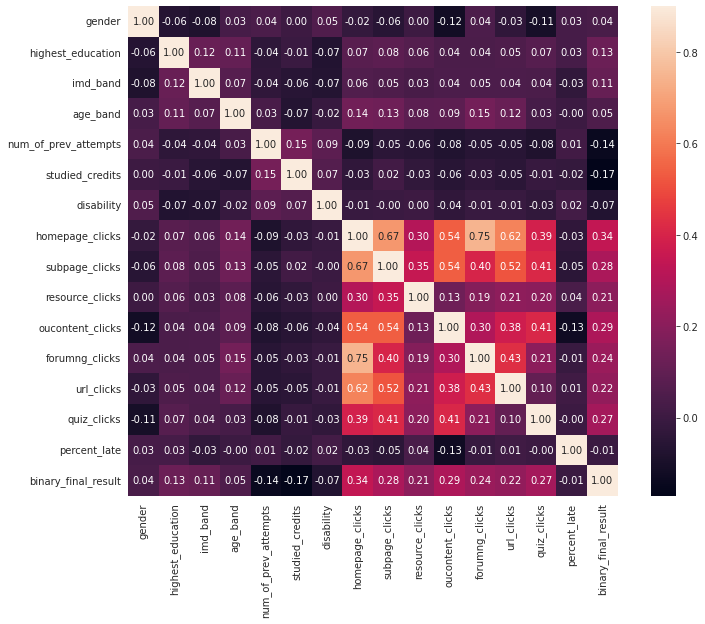

In [188]:
# Plot the Correlation map to see how features are correlated with target: 'binary_final_result'
corr_matrix = predictiveDf.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=0.9,annot=True, fmt='.2f', square=True)

Looking at this correlation matrix and setting an absolute value threshold of 0.1, we will select the following features: 
['highest_education', 'imd_band', 'num_of_prev_attempts', 'studied_credits','homepage_clicks', 'subpage_clicks', 'resource_clicks', 'oucontent_clicks', 'forumng_clicks', 'url_clicks', 'quiz_clicks','assignment1_score']

However, we must be careful to avoid multicollinearity. To ensure this, we will calculate the variance inflation factor on these selected features.

In [201]:
# resource referenced: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
# Calculate the Variance Inflation Factor (VIF)
X = predictiveDf[['highest_education', 'imd_band', 'num_of_prev_attempts', 'studied_credits','homepage_clicks', 'subpage_clicks', 'resource_clicks', 'oucontent_clicks', 'forumng_clicks', 'url_clicks', 'quiz_clicks']]

vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                 feature       VIF
0      highest_education  4.377467
1               imd_band  2.949392
2   num_of_prev_attempts  1.206318
3        studied_credits  3.486347
4        homepage_clicks  7.099928
5         subpage_clicks  3.316743
6        resource_clicks  1.460517
7       oucontent_clicks  2.179517
8         forumng_clicks  2.947204
9             url_clicks  2.273540
10           quiz_clicks  1.748180


A VIF above 5 indicates a high multicollinearity, therefore we will refrain from using 'homepage_clicks'. It is not independent from the other 'click' features, which makes sense.

In [ ]:
X = predictiveDf[['highest_education', 'imd_band', 'num_of_prev_attempts', 'studied_credits', 'subpage_clicks', 'resource_clicks', 'oucontent_clicks', 'forumng_clicks', 'url_clicks', 'quiz_clicks']]
y = predictiveDf[['binary_final_result']]

If we plot a pairplot of the pairwise relationships between our selected features, we are able to confirm that we are ruling out multicollinearity:

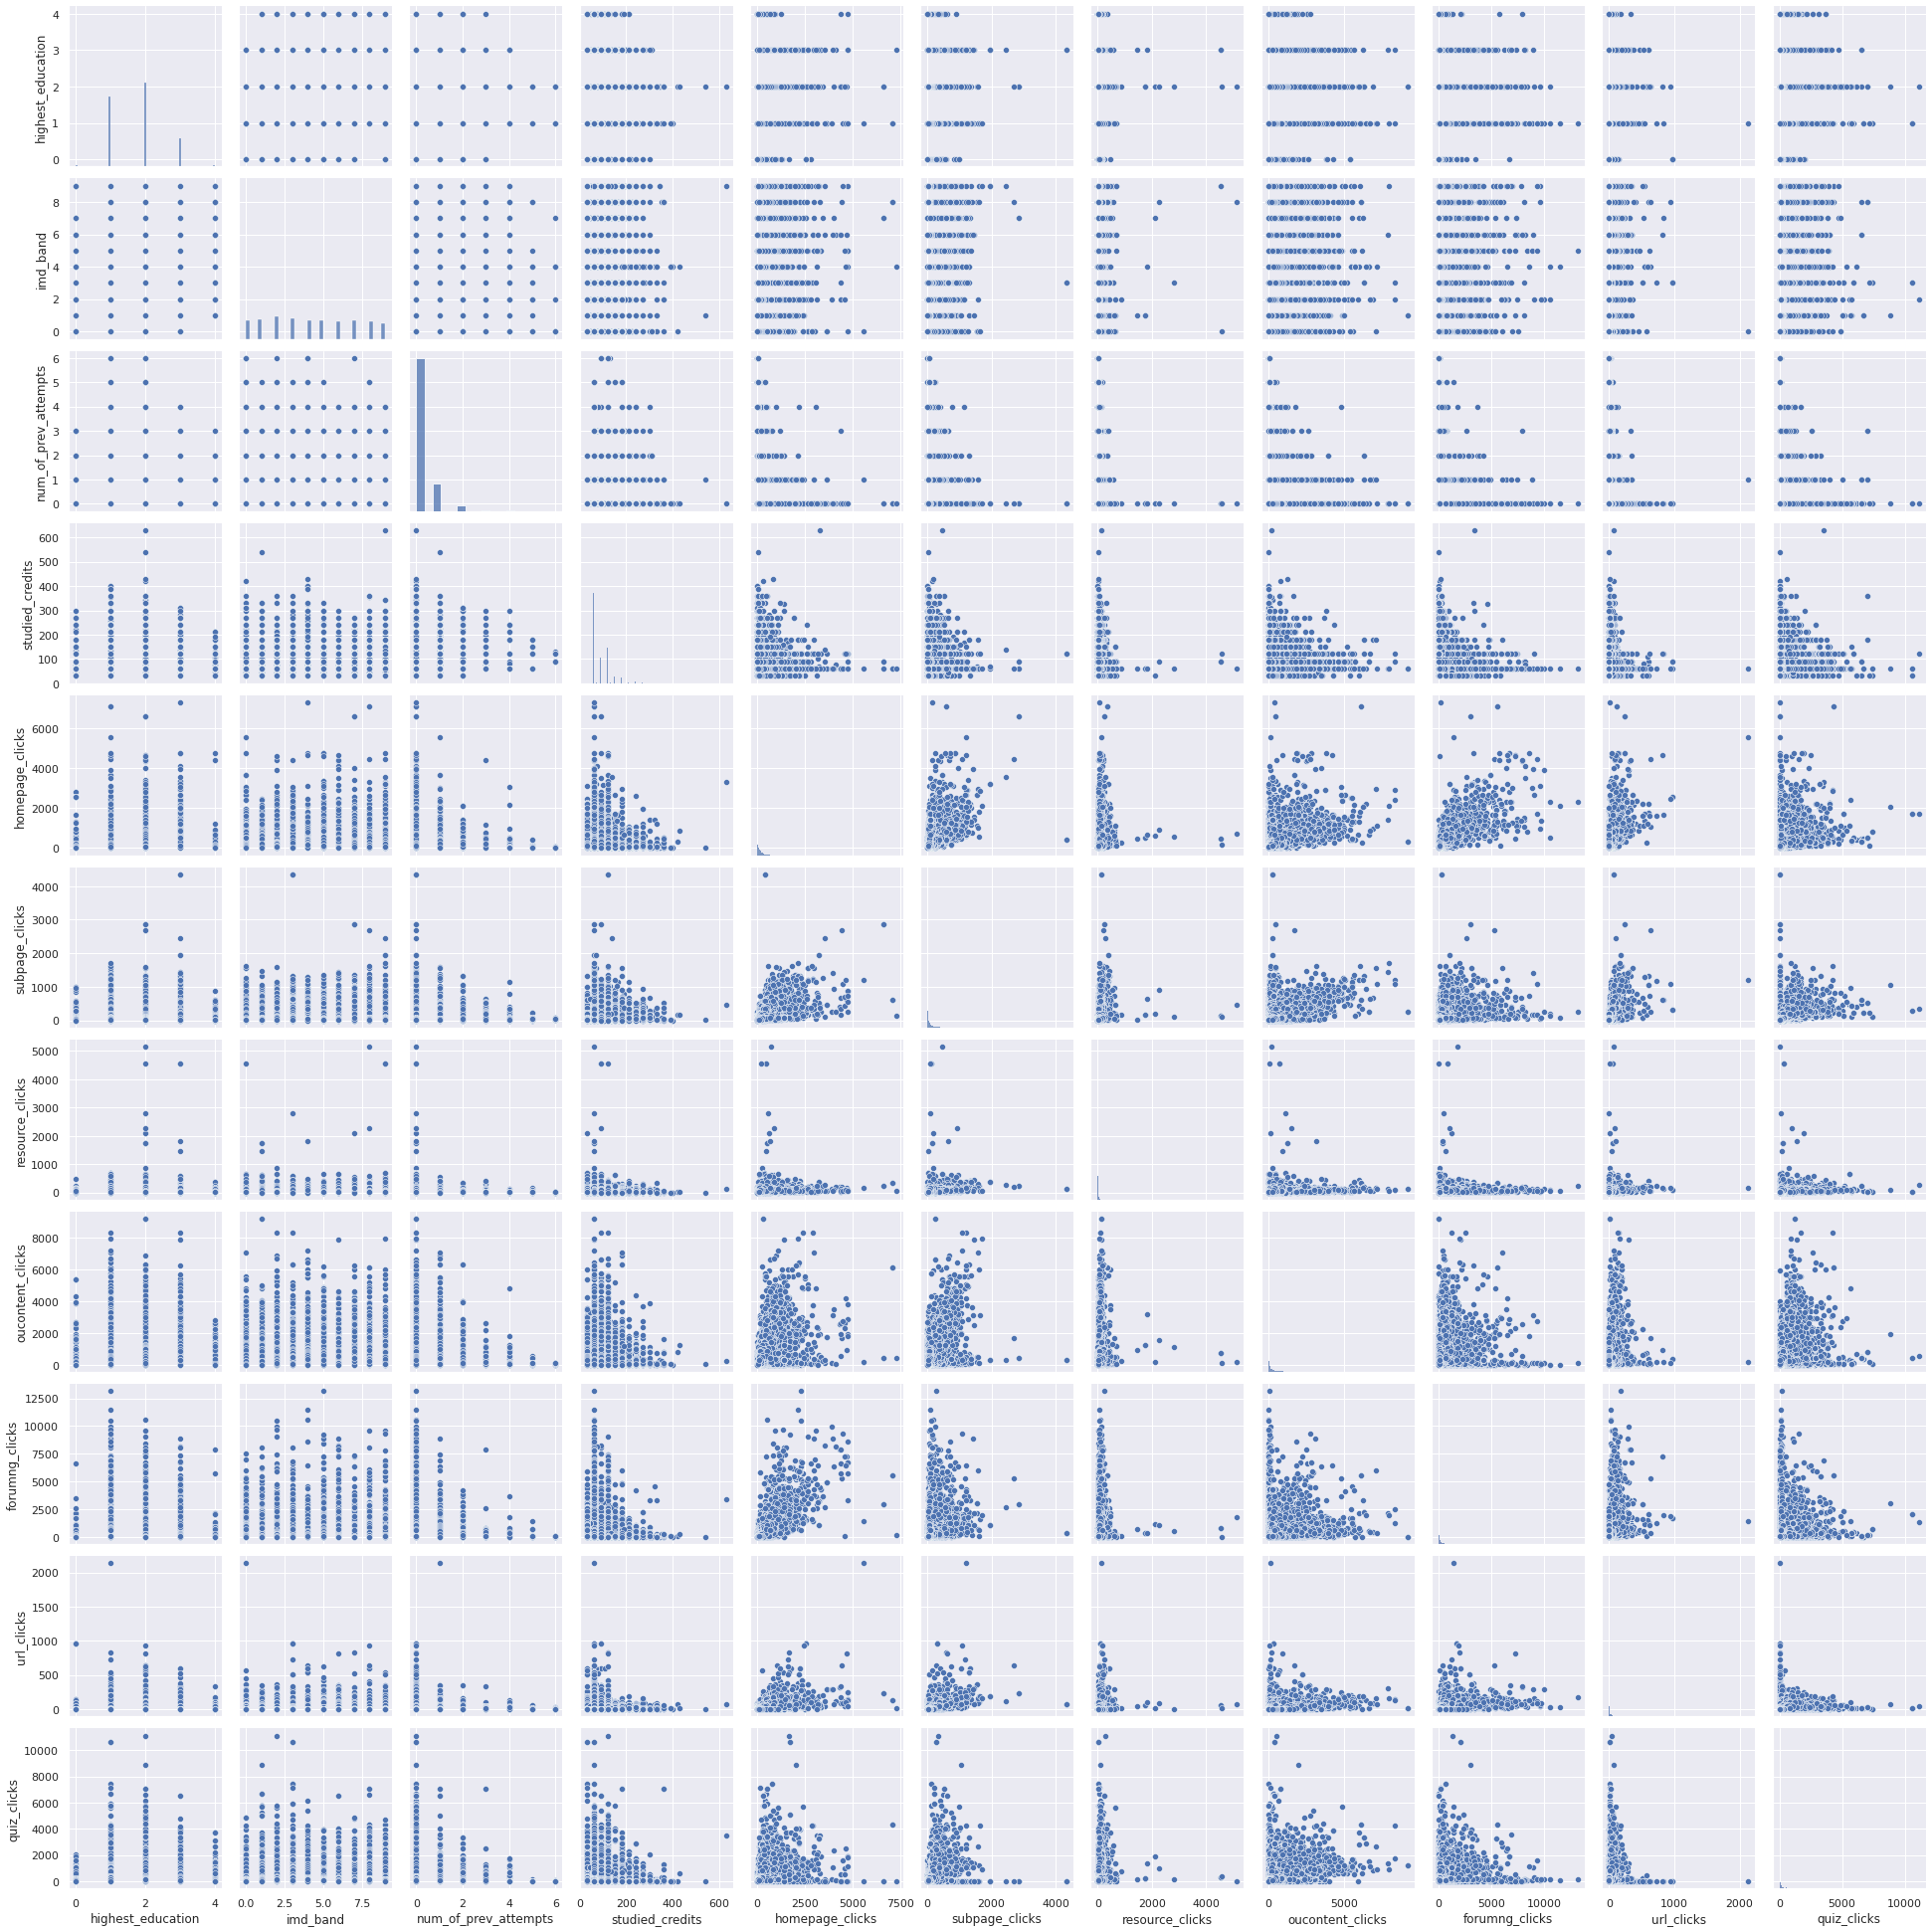

In [202]:
sns.set()
sns.pairplot(X, height = 2.5)
plt.show()

In [193]:
# train-test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
y_train, y_test = y_train.values.ravel(), y_test.values.ravel()

# apply min-max scaler:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression

In [194]:
model = LogisticRegression(random_state=0)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

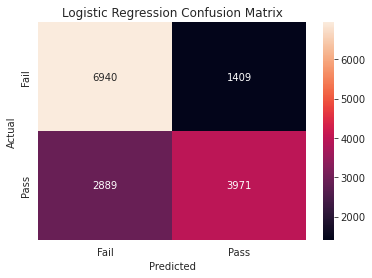

Precision: 0.738
Recall: 0.579
Accuracy: 0.717
F1 Score: 0.649


In [195]:
# Evaluate results:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
x_axis_labels = ['Fail', 'Pass'] # labels for x-axis
y_axis_labels = ['Fail', 'Pass']
sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

#### Random Forest Classifier

In [196]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

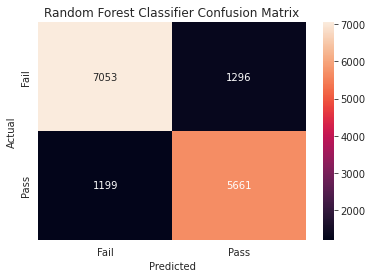

Precision: 0.814
Recall: 0.825
Accuracy: 0.836
F1 Score: 0.819


In [197]:
# Evaluate results:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
x_axis_labels = ['Fail', 'Pass'] # labels for x-axis
y_axis_labels = ['Fail', 'Pass']
sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title('Random Forest Classifier Confusion Matrix')
plt.show()

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

Let's plot feature importance from this random forest classifier in order to determine what factors are most indicative of student success. (Resource referenced: https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python)

Text(0.5, 1.0, 'Random Forest Feature Importance')

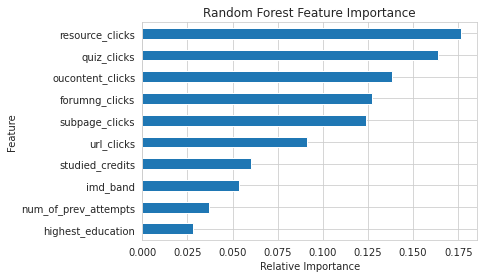

In [198]:
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True) 
feat_importances.plot(kind='barh')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')

Given more time, next steps would involve hyperparameter tuning to improve performance of these models, as well as comparisons of performance against other classification methods, such as Support Vector Machines or Naïve Bayes. 
